In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F



In [2]:


# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Other tools
import time
import os
import copy

/Users/chenyixiong/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/chenyixiong/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/chenyixiong/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/chenyixiong/anaconda3/lib/python3.7/site-packages/tensorf

In [3]:
# Concentrating on the first 100 samples
n_samples = 200

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = []
for i in range (2):
    idx.extend(np.where(X_train.targets == i)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

In [4]:
n_samples = 100

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = []
for i in range (2):
    idx.extend(np.where(X_test.targets == i)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [5]:
n_qubits = 1
num_epoch = 30

In [6]:
dev = qml.device('default.qubit.autograd', wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates. 
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
        
def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis. 
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

In [8]:
@qml.qnode(dev, interface='torch',diff_method='best')
def q_net(q_in):
        
        H_layer(n_qubits)   
        
        RY_layer(q_in)      
       

        return qml.probs(wires=[0])

In [9]:
# binary quantum classifier
class Quantumnet(nn.Module):
        def __init__(self):
            super().__init__()

        def forward(self, q_in):
     
            # Apply the quantum circuit to each element of the batch and append to q_out
            q_out = torch.Tensor(0)
            q_out = q_out.to(device)
        
            for elem in q_in:
            
                q_out_elem = q_net(elem)[0].float().unsqueeze(0)
        
                q_out = torch.cat((q_out, q_out_elem))
   
            return (q_out)


In [10]:
# # Hybrid QCNN model 
class QCNN(nn.Module):
    def __init__(self):
        super(QCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)
        self.quantum = Quantumnet()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(-1,256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.quantum(x)
        return x

In [11]:
def train(model,opimizer,loss_func,train_loader):
    model.train()

    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target.float())
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()

        total_loss.append(loss.item())

    return sum(total_loss)/len(total_loss)


In [12]:
def validation(model,test_loader):
    model.eval()
    with torch.no_grad():
        total_loss = []
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target.float())
            total_loss.append(loss.item())
            if output[0] >= 0.5:
                output[0] = 1
            else:
                output[0] = 0
            if output[0] == target[0]:
                correct += 1      
    loss = sum(total_loss) / len(total_loss)
    acc = correct / len(test_loader) * 100

    return loss, acc

### Performance evaluation of hybrid QCNN model with quantum classifier

In [13]:

model = QCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.BCELoss()
train_loss_list = []
test_loss_list = []
acc_list = []
for epoch in range(num_epoch):
    train_loss = train(model,optimizer,loss_func,train_loader)
    #print(train_loss )
    train_loss_list.append(train_loss)
    test_loss, acc = validation(model,test_loader)
   # print(acc)
    acc_list.append(acc)
    test_loss_list.append(test_loss)
    print('Training [{:.0f}%]\ttrain_Loss: {:.4f}\ttest_acc: {:.1f}%'.format(
        100. * (epoch + 1) / num_epoch, train_loss,acc))
    

Training [3%]	train_Loss: 0.1718	test_acc: 100.0%
Training [7%]	train_Loss: 0.0722	test_acc: 100.0%
Training [10%]	train_Loss: 0.0668	test_acc: 100.0%
Training [13%]	train_Loss: 0.0454	test_acc: 100.0%
Training [17%]	train_Loss: 0.0429	test_acc: 100.0%
Training [20%]	train_Loss: 0.0413	test_acc: 100.0%
Training [23%]	train_Loss: 0.0283	test_acc: 100.0%
Training [27%]	train_Loss: 0.0251	test_acc: 100.0%
Training [30%]	train_Loss: 0.0216	test_acc: 100.0%
Training [33%]	train_Loss: 0.0144	test_acc: 100.0%
Training [37%]	train_Loss: 0.0144	test_acc: 100.0%
Training [40%]	train_Loss: 0.0113	test_acc: 100.0%
Training [43%]	train_Loss: 0.0105	test_acc: 100.0%
Training [47%]	train_Loss: 0.0105	test_acc: 100.0%
Training [50%]	train_Loss: 0.0105	test_acc: 100.0%
Training [53%]	train_Loss: 0.0060	test_acc: 100.0%
Training [57%]	train_Loss: 0.0063	test_acc: 100.0%
Training [60%]	train_Loss: 0.0097	test_acc: 100.0%
Training [63%]	train_Loss: 0.0078	test_acc: 100.0%
Training [67%]	train_Loss: 0.0075

## Plot loss and accurcy curves

Text(0, 0.5, 'Loss')

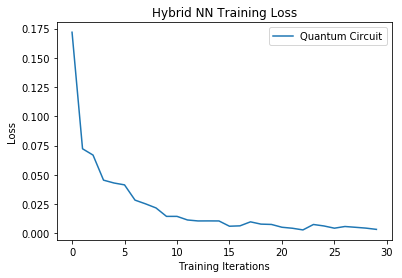

In [14]:
plt.plot(train_loss_list,label='Quantum Circuit')

plt.legend()
plt.title('Hybrid NN Training Loss')
plt.xlabel('Training Iterations')
plt.ylabel('Loss')


Text(0, 0.5, 'Accuracy')

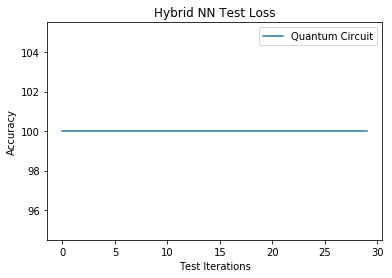

In [15]:
plt.plot(acc_list,label='Quantum Circuit')

plt.legend()
plt.title('Hybrid NN Test Loss')
plt.xlabel('Test Iterations')
plt.ylabel('Accuracy')
